# Unveiling Diabetic Trends: Exploring Lifestyle Patterns for Diagnosis Using Supervised Learning

#### The following cell's code (import statements etc.) is provided for you and you should not need to change it.

In [5]:
# Load packages we need
import sys
import os
import time

import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

# Load the TensorBoard notebook extension
#%load_ext tensorboard


# Let's check our software versions
print('------------')
print('### Python version: ' + __import__('sys').version)
print('### NumPy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')

def var_exists(var_name):
    return (var_name in globals() or var_name in locals())

/var/folders/z6/5n_s73l16t753clskkrk3n180000gq/T/ipykernel_5676/1432771477.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/hansika/Documents/MLE/env/mle/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


------------
### Python version: 3.9.6 (default, Nov 10 2023, 13:38:27) 
[Clang 15.0.0 (clang-1500.1.0.2.5)]
### NumPy version: 1.26.3
### Scikit-learn version: 1.4.0
### Tensorflow version: 2.15.0
------------


#### This is the seed we will use, do not change it.

In [3]:
# set the seed
seed = 42
np.random.seed(seed)

epsf = 1e-9 # small epsilon value for floating point comparisons

### Loading data

In [5]:
diabetes_data = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
print(diabetes_data.shape)

(253680, 22)


In [6]:
diabetes_data.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [7]:
diabetes_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def preprocess_data(data, onehot=True, test_val_prop=0.1, val_prop=0.5, seed=None, verbose=False):

    # Split the data into features and labels
    x_all = data.drop('Diabetes_012', axis=1)
    y_all = data['Diabetes_012']

    if onehot:
        num_classes = 3
        y_all = keras.utils.to_categorical(y_all, num_classes)

    # Split the data into training, validation, and test sets
    train_x, temp_x, train_y, temp_y = train_test_split(x_all, y_all, test_size=test_val_prop, random_state=seed)
    val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size=val_prop, random_state=seed)

    # Standardize the data (need to consider not normalizing the binary and categorical data, instead keepbinary as it is and on-hot encode the categorical)
    scaler = StandardScaler()
    train_x = scaler.fit_transform(train_x)
    val_x = scaler.transform(val_x)
    test_x = scaler.transform(test_x)

    if verbose: 
        print('Shape : train x: {} y: {}, val x: {} y: {}, test shape: {} y: {}'.format(train_x.shape, train_y.shape,
                                                                                      val_x.shape, val_x.shape, test_x.shape, test_y.shape))
    
    return train_x, train_y, test_x, test_y, val_x, val_y


train_x, train_y, test_x, test_y, val_x, val_y = preprocess_data(diabetes_data, onehot=True, seed=seed, verbose=True) 

Shape : train x: (228312, 21) y: (228312, 3), val x: (12684, 21) y: (12684, 21), test shape: (12684, 21) y: (12684, 3)


In [23]:
print(train_x[:5])

[[-0.8660254  -0.85765926  0.19678952  0.54919177 -0.89196265 -0.20577766
  -0.32239386 -1.76195499 -1.31766521 -2.07491281 -0.24397989  0.22681674
  -0.30320241 -0.47884785 -0.42976057 -0.4870846  -0.44968645  1.12784417
  -0.33780938 -0.0504701   0.93983833]
 [ 1.15470054  1.16596421  0.19678952  1.30593967  1.12112318 -0.20577766
  -0.32239386  0.56755139  0.75891812  0.48194796 -0.24397989  0.22681674
  -0.30320241  0.45712043  0.91813652 -0.4870846  -0.44968645  1.12784417
  -0.01039969 -0.0504701   0.45714311]
 [-0.8660254  -0.85765926  0.19678952  0.39784219  1.12112318 -0.20577766
  -0.32239386 -1.76195499 -1.31766521  0.48194796 -0.24397989  0.22681674
  -0.30320241  1.39308871 -0.42976057  2.95421321  2.22377169  1.12784417
  -0.33780938 -1.06400961 -0.50824734]
 [-0.8660254  -0.85765926  0.19678952 -0.3589057  -0.89196265 -0.20577766
  -0.32239386  0.56755139  0.75891812  0.48194796  4.09869852  0.22681674
  -0.30320241  0.45712043 -0.42976057 -0.4870846  -0.44968645 -0.8866

In [ ]:
# Let's create a custom callback class
class PerfEvalCustomCallback(keras.callbacks.Callback):
    
    def __init__(self, perf_data):
        self.perf_data = perf_data
    
    # we define the on_epoch_end callback and save the loss and accuracy in perf_data
    def on_epoch_end(self, epoch, logs=None):
        self.perf_data[epoch,0] = logs['loss']
        self.perf_data[epoch,1] = logs['accuracy']
        self.perf_data[epoch,2] = logs['val_loss']
        self.perf_data[epoch,3] = logs['val_accuracy']

    def get_perf_data():
        return self.perf_data

In [ ]:
# Plot the model's performance during training (across epochs)
def plot_training_perf(train_loss, train_acc, val_loss, val_acc, ax=None, fs=(6,3)):
    no_ax_provided = ax == None
    if no_ax_provided:
        fig = plt.figure(figsize=fs)
        ax = plt.gca()

    assert train_loss.shape == val_loss.shape and train_loss.shape == val_acc.shape and val_acc.shape == train_acc.shape
    
    # assume we have one measurement per epoch
    num_epochs = train_loss.shape[0]
    epochs = np.arange(0, num_epochs)

    ax.plot(1+epochs, train_acc, 'r--', linewidth=2, label='Training')
    ax.plot(1+epochs, val_acc, 'b-', linewidth=2, label='Validation')
    
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    
    ax.set_xlim([1, num_epochs])

    ylim = [0.0, 1.01]
    ax.set_ylim(ylim)

    ax.legend()
    if no_ax_provided:
        plt.show()

In [ ]:

def evaluate_model(name, model, eval_data, 
                   plot_training=True, evaluate_on_test_set=True, provide_classification_report=False):
    
    # unpack the stuff
    perf_data, dataset = eval_data
    train_x, train_y, val_x, val_y, test_x, test_y = dataset
    
    
    train_preds = model.predict(train_x, verbose=0)
    val_preds = model.predict(val_x, verbose=0)
    

    train_accuracy_metric = keras.metrics.CategoricalAccuracy()
    val_accuracy_metric = keras.metrics.CategoricalAccuracy()

    train_accuracy_metric.update_state(train_y, train_preds)
    val_accuracy_metric.update_state(val_y, val_preds)

    train_acc = train_accuracy_metric.result().numpy()
    val_acc = val_accuracy_metric.result().numpy()


    print('[{}] Training Accuracy: {:.3f}%, Validation Accuracy: {:.3f}%'.format(name, 100*train_acc, 100*val_acc))
        
    if evaluate_on_test_set:
        test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)
        assert np.isnan(test_loss) or (test_loss == float(test_loss) and test_loss >= -1e8)
        assert np.isnan(test_acc) or (test_acc == float(test_acc) and test_acc >= 0 and test_acc < 1.0)
        print('[{}] Test loss: {:.5f}, test accuracy: {:.3f}%'.format(name, test_loss, 100*test_acc))

    if plot_training:
        plot_training_perf(perf_data[:,0], perf_data[:,1], perf_data[:,2], perf_data[:,3])
    
    if provide_classification_report:
        test_preds_indices = model.predict(test_x, verbose=0).argmax(axis=1)
        test_y_indices = np.argmax(test_y, axis=1)
        print("\n--- Classification Report (Test Set) ---")
        print(sklearn.metrics.classification_report(test_y_indices, test_preds_indices))
    return


def train_model(model, max_epochs=25, batch_size=128, verbose=0, 
                   dataset=(train_x, train_y, val_x, val_y, test_x, test_y)):

    ## unpack dataset
    train_x, train_y, val_x, val_y, test_x, test_y = dataset
    
    early_stop_cb = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=40)
    
    perf_data = np.zeros((max_epochs, 4))
    perf_eval_cb = PerfEvalCustomCallback(perf_data)
    
    hobj = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size, 
                     shuffle=True, callbacks=[perf_eval_cb, early_stop_cb], verbose=verbose)
    
    eff_epochs = len(hobj.history['loss'])
    eval_data = (perf_data[0:eff_epochs,:], dataset)
    
    return eval_data

In [30]:
def create_compile_model(input_shape=21, hidden_widths=[300, 100], num_outputs=3, verbose=True):
    name = 'diabetes_ANN_model'
    
    model = keras.models.Sequential(name=name)
    
    model.add(keras.Input(shape=(input_shape,), sparse=False)) 
    
    for i, hw in enumerate(hidden_widths):
        model.add(keras.layers.Dense(hw, activation='relu', name='hidden_{}'.format(i), 
                                     kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(1/hw)),
                                     bias_initializer=keras.initializers.Zeros()))
        
    model.add(keras.layers.Dense(num_outputs, activation='softmax', name='output',
                                kernel_initializer=keras.initializers.RandomNormal(stddev=np.sqrt(0.1)),
                                bias_initializer=keras.initializers.Zeros()))
    
    opt = keras.optimizers.Adam(learning_rate=0.002)
    
    if verbose:
        model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [31]:

name, model = create_compile_model() 
eval_data = train_model(model, verbose=1)

Model: "diabetes_ANN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 300)               6600      
                                                                 
 hidden_1 (Dense)            (None, 100)               30100     
                                                                 
 output (Dense)              (None, 3)                 303       
                                                                 
Total params: 37003 (144.54 KB)
Trainable params: 37003 (144.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
1784/1784 [==============================] - 1s 706us/step - loss: 0.4008 - accuracy: 0.8478 - val_loss: 0.3948 - val_accuracy: 0.8504
Epoch 2/25
1784/1784 [==============================] - 1s 633us/step - loss: 0.3953 - accuracy: 0.8490 - val_loss: 0.3923 - val

[diabetes_ANN_model] Training Accuracy: 86.013%, Validation Accuracy: 84.603%
[diabetes_ANN_model] Test loss: 0.41219, test accuracy: 84.445%


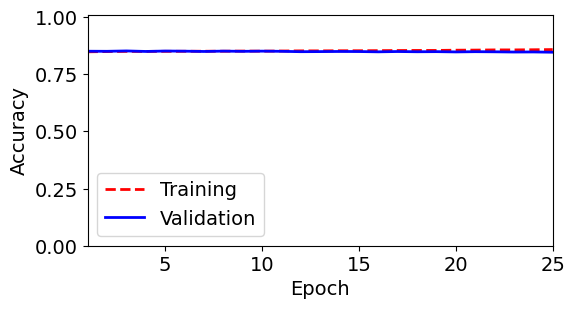

In [32]:
evaluate_model(name, model, eval_data)